# 🐶 Project: "What is Laika?" – A Breed Analysis

## 1. Problem Definition
My sister's dog, Laika, is a mystery mix. We have our guesses about her heritage, but I want an objective opinion.

The goal of this project is to use **fastai and a ResNet34 model** to analyze her features. By training the model on purebred dogs that visually resemble Laika, I aim to see which breed the AI identifies as her dominant lineage.

## 2. Motivation
* **The Family Debate:** We finally want a data-driven answer to "What is she?"
* **The Challenge:** This is "Fine-Grained Image Classification." Unlike distinguishing a Cat from a Dog, distinguishing a German Shepherd from a Belgian Malinois requires the model to learn subtle details like ear shape and snout structure.

## 3. The Dataset & Classes
I filtered the **Stanford Dogs Dataset** (via HuggingFace) to include only the 7 breeds that actually look like Laika:

1.  **German Shepherd**
2.  **Belgian Malinois**
3.  **Rottweiler**
4.  **Doberman**
5.  **Collie**
6.  **Gordon Setter**
7.  **Groenendael**

## 4. Expected Challenges
* **The "Mix" Factor:** The model is trained on purebred labels, but Laika is a mix. I don't expect a single 100% confident prediction; instead, I'm looking for a split probability distribution that hints at her mix.
* **Visual Similarity:** Because I intentionally chose breeds that look alike, the model will have a harder time distinguishing classes compared to a random dataset.

In [20]:
from fastai.vision.all import *
from PIL import Image
import matplotlib.pyplot as plt
import torch
from collections import Counter

## The data

In [22]:
data_path = Path('./data')
laika_path = Path('./Laika')

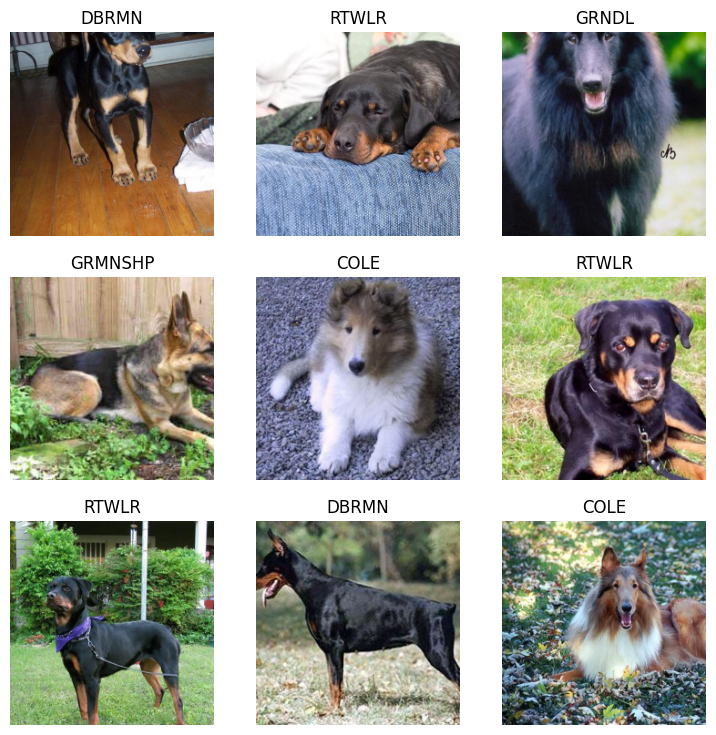

In [23]:
# Load the data
dls = ImageDataLoaders.from_folder(
    data_path,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(224)
)

dls.show_batch()

## Laika

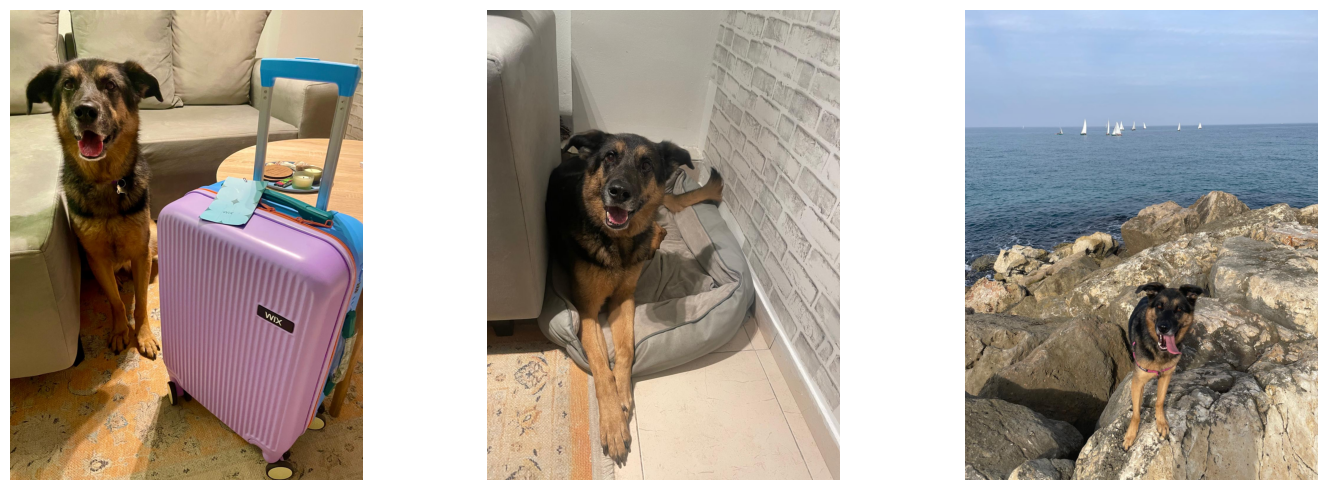

In [28]:
files = get_image_files(laika_path)

# Pick 3 random images
selected_files = random.sample(list(files), 3)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, img_path in enumerate(selected_files):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [29]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.906142,0.192408,0.065728,00:55


epoch,train_loss,valid_loss,error_rate,time
0,0.296839,0.221486,0.079812,01:17
1,0.229451,0.201083,0.070423,01:58
2,0.162463,0.170163,0.042254,02:19
3,0.126372,0.164549,0.051643,01:20


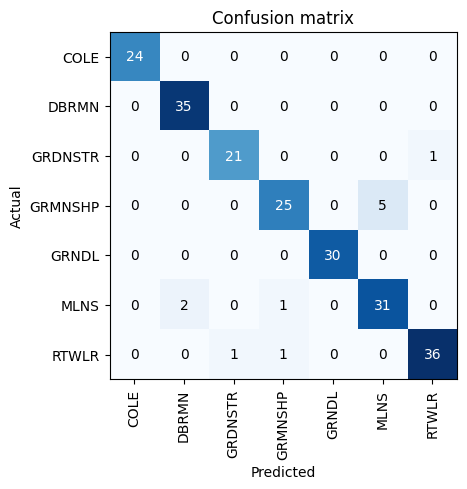

In [30]:
interp = ClassificationInterpretation.from_learner(learn)

# Plot the Confusion Matrix
interp.plot_confusion_matrix()

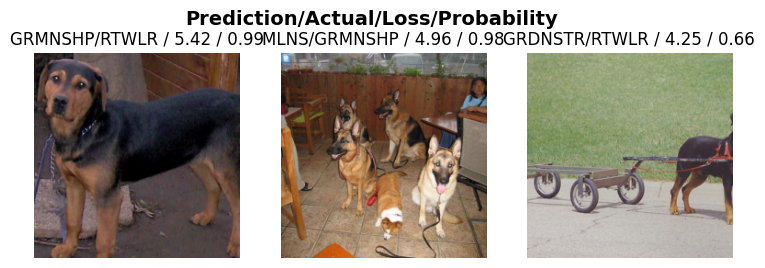

In [31]:
# Plot the images with the highest loss (most confident wrong predictions)
interp.plot_top_losses(3, nrows=1)

In [32]:
test_path = Path('./Laika')
test_files = get_image_files(test_path)
test_dl = learn.dls.test_dl(test_files)

# Get predictions once
preds, _ = learn.get_preds(dl=test_dl)

In [33]:
# Chart 1: Hard Predictions
predicted_indices = preds.argmax(dim=1)
predicted_labels = [learn.dls.vocab[i] for i in predicted_indices]
counts = Counter(predicted_labels)
print(f"Raw Prediction Counts: {counts}")

# Logic for Chart 2: Average Probabilities
avg_probs = torch.mean(preds, dim=0).numpy()
class_names = learn.dls.vocab
print("\nAverage Probability Distribution:")
for name, prob in zip(class_names, avg_probs):
    print(f"{name}: {prob:.4f}")

Raw Prediction Counts: Counter({'GRMNSHP': 53, 'RTWLR': 8, 'DBRMN': 3, 'MLNS': 3})

Average Probability Distribution:
COLE: 0.0210
DBRMN: 0.0730
GRDNSTR: 0.0130
GRMNSHP: 0.6980
GRNDL: 0.0059
MLNS: 0.0661
RTWLR: 0.1230


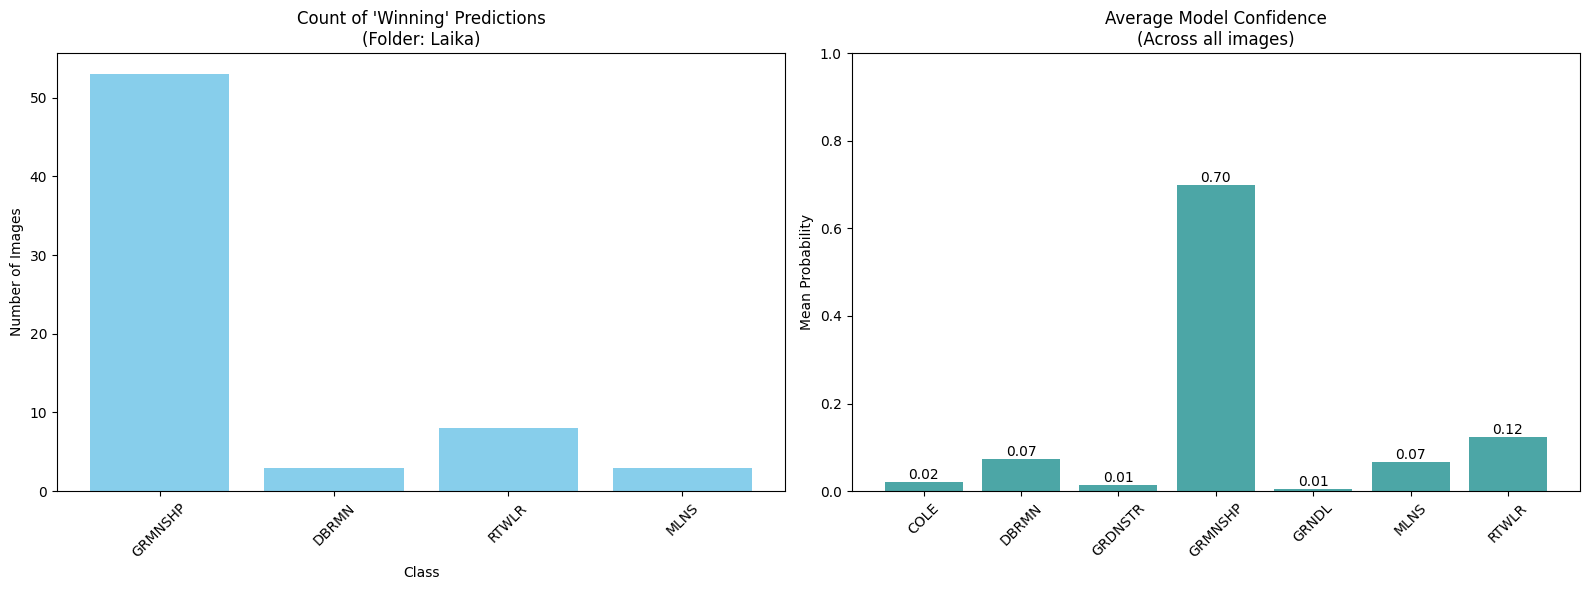

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Prediction Counts
ax1.bar(counts.keys(), counts.values(), color='skyblue')
ax1.set_title(f"Count of 'Winning' Predictions\n(Folder: {test_path.name})")
ax1.set_xlabel("Class")
ax1.set_ylabel("Number of Images")
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Average Probability
bars = ax2.bar(class_names, avg_probs, color='teal', alpha=0.7)
ax2.set_title("Average Model Confidence\n(Across all images)")
ax2.set_ylabel("Mean Probability")
ax2.set_ylim(0, 1.0)
ax2.tick_params(axis='x', rotation=45)

# Add value labels on top of bars for the probability chart
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()